# 因果デジタルツイン

このノートブックではBottomUpParceLiNGAMモデルによる因果デジタルツインを検証する。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from lingam.utils import make_dot

from common import CausalDigitalTwin, generate_test_data, discretize, draw_hist, make_tables, draw_pred_hist

np.random.seed(0)

## 因果デジタルツインのクラス

## 1. データ生成

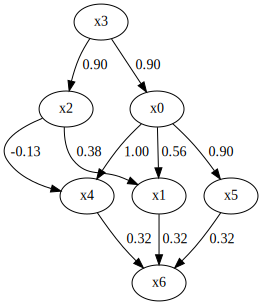

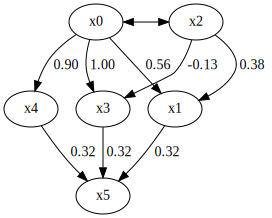

In [2]:
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
causal_order = [3, 0, 2, 1, 4, 5, 6]
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
sink_index = 6
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true, lower_limit=0))

# DirectLiNGAMとまったく同じなので省略

# 未観測化
delete_index = 3
causal_graph_true_unobs = causal_graph_true.copy()
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=0)
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=1)
causal_graph_true_unobs[0, 2] = np.nan
causal_graph_true_unobs[2, 0] = np.nan
display(make_dot(causal_graph_true_unobs, lower_limit=0))
sink_index_unobs = 5

# データ生成関数：未観測化はこの関数内で行う
def data_gen_unobs_common(causal_graph_unobs, errors):
    # 上から渡されるのはcausal_graph_unobsと未観測共通原因の誤差項を含むerror
    delete_index = 3
    
    # 未観測化前の真の因果グラフと真の因果グラフ
    causal_graph_true
    causal_graph_true_unobs
    
    # 未観測入りのDAGから変更点を抽出する
    pos = np.argwhere(~np.isclose(causal_graph_true_unobs - causal_graph_unobs, 0))
    
    # 未観測化前の因果グラフを作成する。変更点を追加していく。
    causal_graph = causal_graph_true.copy()
    
    # 変更点を修正する
    for r, c in pos:
        # delete_indexを消しているのでdelete_index以降の番号はひとつふやす
        r = r + int(delete_index >= r)
        c = c + int(delete_index >= c)
        causal_graph[r, c] = causal_graph_unobs[r, c]       
    
    # 元の因果グラフで作って、変数を削除する。
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    X = np.delete(X, delete_index, axis=0)
    X = np.delete(X, delete_index, axis=1)
    
    # そのまま。未観測の分も誤差項がないとデータを作りようがない。
    #errors = np.delete(errors, delete_index, axis=1)
    
    return X, errors

## 2. 実験

In [3]:
# 実験間で共通のデータ

# 誤差項
error = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    error.append(np.random.uniform(-a, a, size=1000))
error = np.array(error).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 評価関数
eval_funcs_c = {"mse": mean_squared_error}
eval_funcs_d = {"precision": precision_score, "recall": recall_score}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true_unobs))]
is_discrete[sink_index_unobs] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x2->x1, x0->x1を削除)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[1, 2] = 0
causal_graph[1, 0] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x1->x3を追加)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 1] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x3を10倍に設定)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    cdt = CausalDigitalTwin(causal_graph_true_unobs, error, data_gen_unobs_common, sink_index_unobs, cd_algo_name="BottomUpParceLiNGAM")
    result = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(continuous)", ml_models_c["rf"].best_params_)
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    def data_gen_direct_lingam_d(causal_graph, error):
        X_d, error_ = data_gen_unobs_common(causal_graph, error)
        return discretize(X_d, sink_index_unobs), error
    cdt = CausalDigitalTwin(causal_graph_true_unobs, error, data_gen_direct_lingam_d, sink_index_unobs, is_discrete=is_discrete, cd_algo_name="BottomUpParceLiNGAM")
    result_d = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(discrete)", ml_models_d["rf"].best_params_)
    
    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # 値はCausalDigitalTwin.run()の返り値に正解データを足したもの。 
    # 値： evals, predicted_values, simulated, X
    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

remove cv_results_(continuous) {'n_estimators': 200}
remove cv_results_(discrete) {'n_estimators': 200}
add cv_results_(continuous) {'n_estimators': 200}
add cv_results_(discrete) {'n_estimators': 50}
modify cv_results_(continuous) {'n_estimators': 50}
modify cv_results_(discrete) {'n_estimators': 100}


## 実験結果

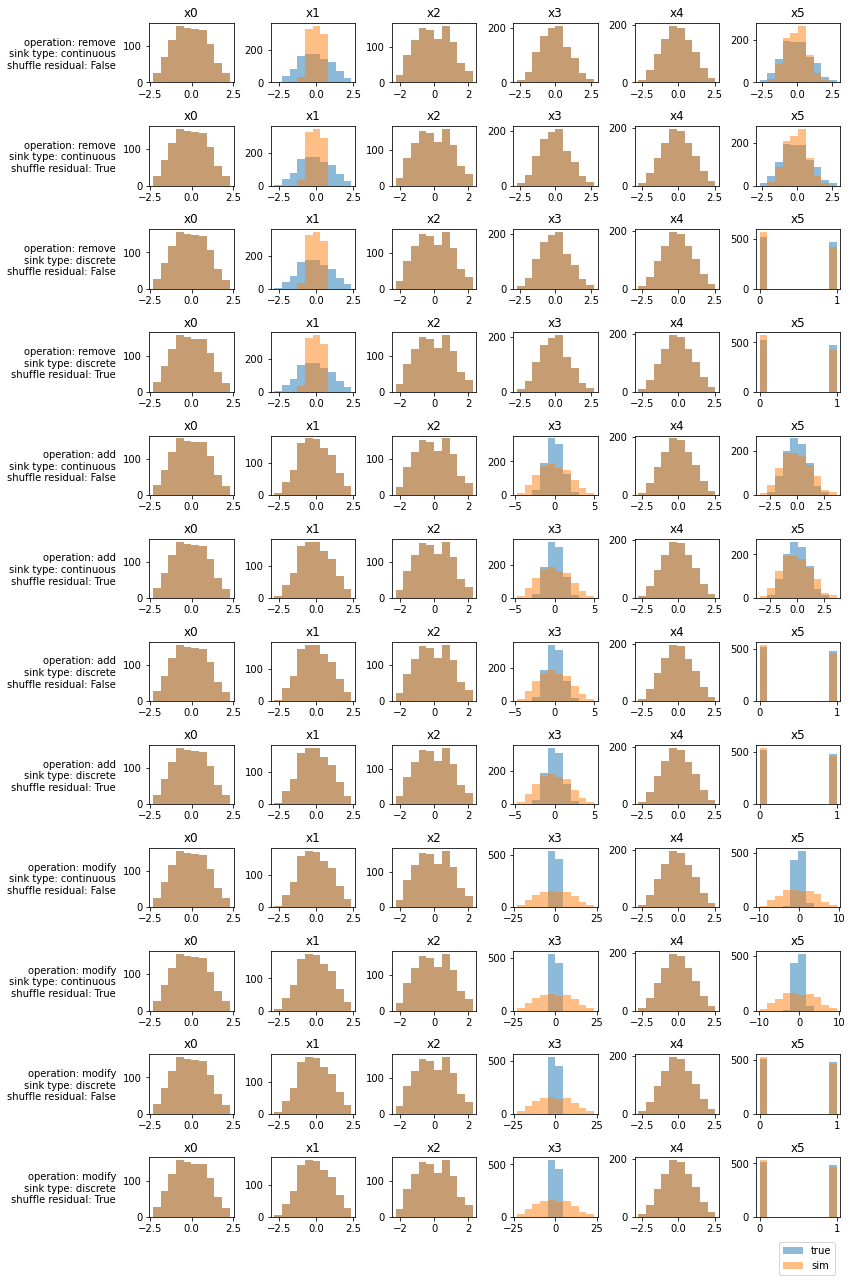

In [4]:
# 環境変化前の真のデータと環境変化後のシミュレーションデータ
n_features = len(causal_graph_true_unobs)
n_patterns = len(results) * len(results["add"])
draw_hist(n_features, n_patterns, results)

In [5]:
# シンク変数に対する機械学習モデルの精度
table_c, table_d = make_tables(results)
display(table_c.style.hide(axis="index"))
display(table_d.style.hide(axis="index"))

operation,model,shuffle error,MSE(true),MSE(sim),MSE(est)
remove,LinearRegression,False,0.199,0.254,0.199
remove,RandomForestRegressor,False,0.032,0.090,0.173
remove,LinearRegression,True,0.199,1.249,0.199
remove,RandomForestRegressor,True,0.032,1.294,0.175
add,LinearRegression,False,0.199,0.306,0.199
add,RandomForestRegressor,False,0.033,0.138,0.086
add,LinearRegression,True,0.199,2.760,0.199
add,RandomForestRegressor,True,0.032,2.840,0.086
modify,LinearRegression,False,0.199,10.109,0.199
modify,RandomForestRegressor,False,0.032,9.912,0.033


operation,model,shuffle error,Precision(true),Precision(sim),Precision(est),Recall(true),Recall(sim),Recall(est)
remove,LinearRegression,False,0.674,0.632,0.622,0.621,0.586,0.597
remove,RandomForestRegressor,False,1.000,0.631,0.593,1.000,0.593,0.617
remove,LinearRegression,True,0.674,0.466,0.635,0.621,0.422,0.596
remove,RandomForestRegressor,True,1.000,0.469,0.587,1.000,0.430,0.596
add,LinearRegression,False,0.671,0.659,0.664,0.628,0.654,0.647
add,RandomForestRegressor,False,1.000,0.657,0.608,1.000,0.652,0.611
add,LinearRegression,True,0.671,0.477,0.667,0.628,0.454,0.623
add,RandomForestRegressor,True,1.000,0.477,0.617,1.000,0.454,0.586
modify,LinearRegression,False,0.664,0.650,0.653,0.634,0.637,0.635
modify,RandomForestRegressor,False,1.000,0.655,0.595,1.000,0.640,0.606


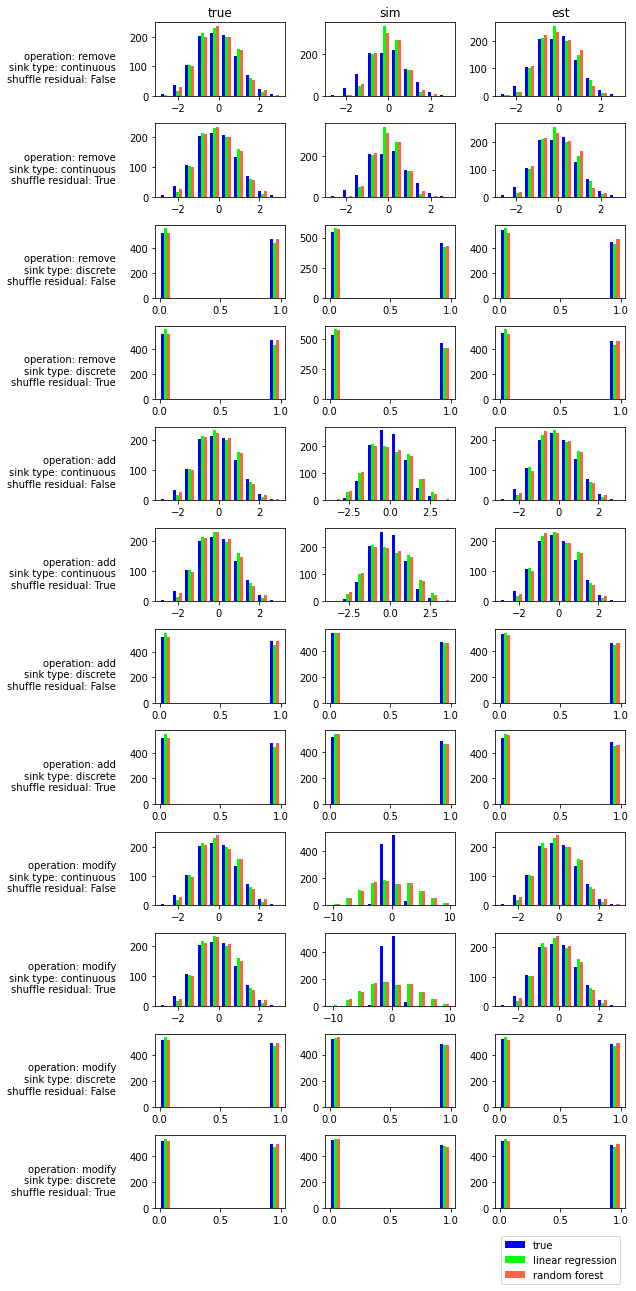

In [6]:
n_patterns = len(results) * len(results["add"])
draw_pred_hist(n_patterns, results, sink_index_unobs)